In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

### Data Pre-processing

In [2]:
train_locs = pd.read_csv('train_locs.csv')
train_pbp = pd.read_csv('train_pbp.csv')
test_locs = pd.read_csv('test_locs.csv')
test_pbp = pd.read_csv('test_pbp.csv')

In [3]:
train_locs

,id,court_x,court_y,annotation_code
0,2-2,72.807686,37.409669,d1
1,2-2,79.080643,31.477796,d2
2,2-2,69.956321,24.467300,d3
3,2-2,75.468933,13.861763,d4
4,2-2,84.973496,19.254422,d5
...,...,...,...,...
308045,5020-52,70.669644,7.270347,s
308046,5020-52,86.958520,4.382292,t1
308047,5020-52,58.962087,26.764930,t2
308048,5020-52,76.777949,20.427222,t3


#### Joining the datasets on the unique id

In [4]:
training_data = train_locs.copy()
testing_data = test_locs.copy()

In [5]:
training_data

,id,court_x,court_y,annotation_code
0,2-2,72.807686,37.409669,d1
1,2-2,79.080643,31.477796,d2
2,2-2,69.956321,24.467300,d3
3,2-2,75.468933,13.861763,d4
4,2-2,84.973496,19.254422,d5
...,...,...,...,...
308045,5020-52,70.669644,7.270347,s
308046,5020-52,86.958520,4.382292,t1
308047,5020-52,58.962087,26.764930,t2
308048,5020-52,76.777949,20.427222,t3


#### Creating new columns that represent whether each player is on offense or defense and whether or not they are the shooter
- these new columns capture the important details about each player as the number in the annotation code does not matter

In [6]:
training_data['offense'] = training_data['annotation_code'].apply(lambda x: 0 if 'd' in x else 1)
testing_data['offense'] = testing_data['annotation_code'].apply(lambda x: 0 if 'd' in x else 1)
training_data['shooter'] = training_data['annotation_code'].apply(lambda x: 1 if 's' in x else 0)
testing_data['shooter'] = testing_data['annotation_code'].apply(lambda x: 1 if 's' in x else 0)

In [7]:
training_data

,id,court_x,court_y,annotation_code,offense,shooter
0,2-2,72.807686,37.409669,d1,0,0
1,2-2,79.080643,31.477796,d2,0,0
2,2-2,69.956321,24.467300,d3,0,0
3,2-2,75.468933,13.861763,d4,0,0
4,2-2,84.973496,19.254422,d5,0,0
...,...,...,...,...,...,...
308045,5020-52,70.669644,7.270347,s,1,1
308046,5020-52,86.958520,4.382292,t1,1,0
308047,5020-52,58.962087,26.764930,t2,1,0
308048,5020-52,76.777949,20.427222,t3,1,0


#### Feature Engineering Shot Distance from the basket
- A dangerous assumption is made here that the basket closest to the shot is the one being shot at, however given that most times a shot is taken from the other side of the court, time expires, there is likely very few such data points.
- Longer shots will likely lead to long rebounds which makes an offensive rebound more likely
- Shots very close to the basket may also be more likely to be offensive rebounded because the shooter could be in good position to rebound or they may have broken down the defense and drawn help away from a rim crasher

In [60]:
# Define the coordinates of the hoop
hoop_coordinates = np.array([[4, 25], [90, 25]])

# Calculate the distance of each shot from the basket
def calculate_shooter_distance_from_hoop(row):
    shot_coordinates = np.array([row['court_x'], row['court_y']])
    distance = np.linalg.norm(shot_coordinates - hoop_coordinates, axis=1)
    if distance[0] < distance[1]:
        hoop = 0
    else:
        hoop = 1
    return pd.Series([np.min(distance), hoop])

In [59]:
shooter_data_test[:5].apply(calculate_shooter_distance_from_hoop, axis=1)

[24.2457772  10.24651436]
[25.05108447 67.38904328]
0
[65.99980164 18.59585322]
[62.32967591 24.83993997]
1
[13.97291853 32.42072325]
[12.43085828 76.38837772]
0
[29.42640473 25.67361135]
[25.43532602 60.57734061]
0
[24.57108307 37.60030086]
[24.12337125 66.63115452]
0


,0,1
5,25.051084,0.0
15,24.839940,1.0
25,12.430858,0.0
35,25.435326,0.0
45,24.123371,0.0


In [61]:
shooter_data_train = training_data.loc[training_data.annotation_code == 's']
shooter_data_test = testing_data.loc[testing_data.annotation_code == 's']

In [62]:
# Hoop at x = 4 is 0, x = 90 is 1
shooter_data_train[['distance_from_hoop', 'which_hoop']] = shooter_data_train.apply(calculate_shooter_distance_from_hoop, axis=1)
shooter_data_test[['distance_from_hoop', 'which_hoop']] = shooter_data_test.apply(calculate_shooter_distance_from_hoop, axis=1)

C:\Users\timse\AppData\Local\Temp\ipykernel_20052\2934421334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shooter_data_train[['distance_from_hoop', 'which_hoop']] = shooter_data_train.apply(calculate_shooter_distance_from_hoop, axis=1)
C:\Users\timse\AppData\Local\Temp\ipykernel_20052\2934421334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shooter_data_test[['distance_from_hoop', 'which_hoop']] = shooter_data_test.apply(calculate_shooter_distance_from_hoop, axis=1)


In [63]:
shooter_data_test

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,distance_from_hoop
5,1-1,24.245777,10.246514,s,1,1,0.0,25.051084
15,2-1,65.999802,18.595853,s,1,1,1.0,24.839940
25,2-5,13.972919,32.420723,s,1,1,0.0,12.430858
35,2-7,29.426405,25.673611,s,1,1,0.0,25.435326
45,3-2,24.571083,37.600301,s,1,1,0.0,24.123371
...,...,...,...,...,...,...,...,...
131975,5020-38,73.369204,6.589166,s,1,1,1.0,24.810122
131985,5020-44,10.383696,23.385000,s,1,1,0.0,6.584816
131995,5020-45,63.967513,21.630555,s,1,1,1.0,26.249639
132005,5020-50,86.769934,45.832432,s,1,1,1.0,21.081356


Let's investigate the relationship between shot distance and offensive rebounds

In [12]:
shot_distance = shooter_data_train.copy()

In [13]:
train_pbp['is_oreb']

0        0
1        0
2        0
3        1
4        0
        ..
30800    0
30801    1
30802    1
30803    1
30804    0
Name: is_oreb, Length: 30805, dtype: int64

In [14]:
shot_distance['oreb'] = train_pbp['is_oreb'].values

In [15]:
shot_distance

,id,court_x,court_y,annotation_code,offense,shooter,distance_from_hoop,which_hoop,oreb
5,2-2,69.994331,39.674616,s,1,1,24.810706,1.0,0
15,2-3,16.896578,13.154704,s,1,1,17.510933,0.0,0
25,2-4,87.963438,3.638889,s,1,1,21.457974,1.0,0
35,2-6,80.185287,22.850748,s,1,1,10.047281,1.0,1
45,2-8,70.659638,39.791936,s,1,1,24.348532,1.0,0
...,...,...,...,...,...,...,...,...,...
308005,5020-46,75.406582,43.315000,s,1,1,23.418093,1.0,0
308015,5020-47,34.976740,28.423749,s,1,1,31.165373,0.0,1
308025,5020-48,12.023261,24.935416,s,1,1,8.023521,0.0,1
308035,5020-49,63.025313,12.659930,s,1,1,29.663295,1.0,1


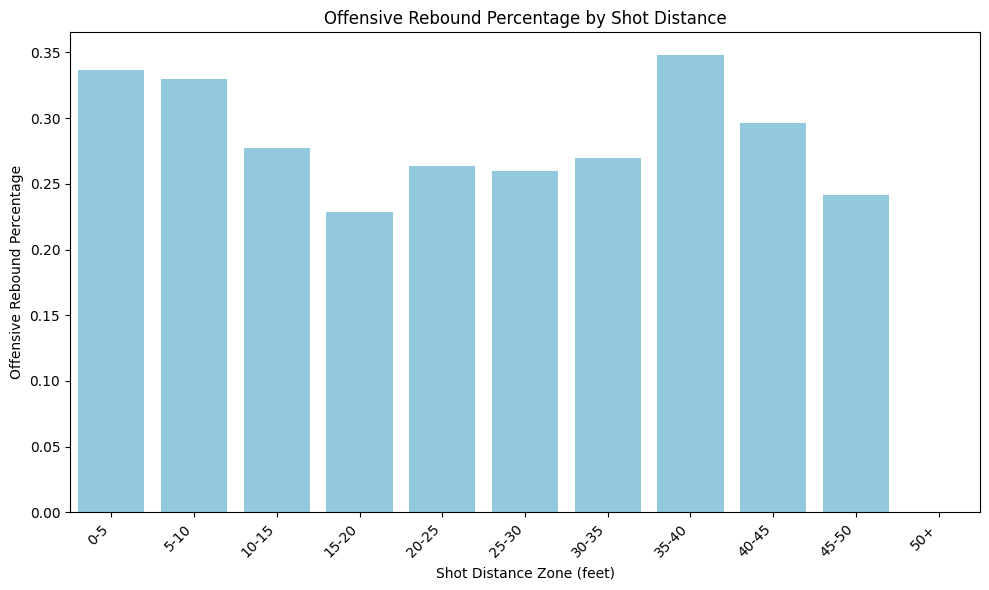

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Categorize each shot into the corresponding zones based on shot distance
shot_distance_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, np.inf]
zone_labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50+']
shot_distance['shot_distance_zone'] = pd.cut(shot_distance['distance_from_hoop'], bins=shot_distance_bins, labels=zone_labels, right=False)

# Calculate the offensive rebound percentage for each shot distance zone
oreb_by_zone = shot_distance.groupby('shot_distance_zone')['oreb'].mean()

# Create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=oreb_by_zone.index, y=oreb_by_zone.values, color='skyblue')
plt.title('Offensive Rebound Percentage by Shot Distance')
plt.xlabel('Shot Distance Zone (feet)')
plt.ylabel('Offensive Rebound Percentage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Feature Engineering Average Distance of Defenders from the basket
- This feature will inform the spacing of the court at the time of the shot
- The further out the defense is, the harder it will be to box out and the more lanes there will be for offensive players to crash the boards
- There is even more risk here that a player will be on the other side of the court
    - The ground truth shooting hoop will be considered what hoop the shooter is closer to in order to maintain consistency despite the uncertainty

In [17]:
def calculate_def_distance_from_hoop(row):
    # Define the coordinates of the hoop
    hoop_coordinates = np.array([[4.0, 25.0], [90.0, 25.0]])  # Ensure the elements are floats
    def_coordinates = np.array([row['court_x'], row['court_y']])
    
    # Calculate the distance
    distance = np.linalg.norm(def_coordinates - hoop_coordinates[int(row['which_hoop'])])
    return distance

In [18]:
training_data = training_data.merge(shooter_data_train[['id', 'which_hoop']], left_on='id', right_on='id')
testing_data = testing_data.merge(shooter_data_test[['id', 'which_hoop']], left_on='id', right_on='id')

In [19]:
defenders_distance_train = training_data.loc[training_data.offense == 0]
defenders_distance_test = testing_data.loc[testing_data.offense == 0]

In [20]:
defenders_distance_train['def_distance'] = defenders_distance_train.apply(calculate_def_distance_from_hoop, axis=1)
defenders_distance_test['def_distance'] = defenders_distance_test.apply(calculate_def_distance_from_hoop, axis=1)

C:\Users\timse\AppData\Local\Temp\ipykernel_20052\4184772301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defenders_distance_train['def_distance'] = defenders_distance_train.apply(calculate_def_distance_from_hoop, axis=1)
C:\Users\timse\AppData\Local\Temp\ipykernel_20052\4184772301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defenders_distance_test['def_distance'] = defenders_distance_test.apply(calculate_def_distance_from_hoop, axis=1)


In [21]:
def_mean_distances_train = defenders_distance_train.groupby('id')['def_distance'].mean()
def_mean_distances_test = defenders_distance_test.groupby('id')['def_distance'].mean()

#### Feature Engineering Measurement of Rebound Positioning

##### Assigning box out responsibilities

*Offensive Rebounding Player Assignment Algorithm*

This algorithm is designed to optimize the assignment of defensive players to their respective offensive players during a basketball game to enhance the team's chances of securing an defensive rebound.

Step 1: Creating a Spatial Graph

The algorithm starts by constructing a spatial graph that represents the relationships between offensive players and the hoop (basket). Each offensive player and the hoop are represented as nodes in the graph, and edges are added between offensive players based on their spatial proximity. This graph reflects the players' positioning on the court and helps identify the most strategic offensive players to box out.

Step 2: Betweenness Centrality

The algorithm then calculates a measure called "betweenness centrality" for each offensive player in the graph. This metric quantifies how often an offensive player lies on the shortest path between other offensive players and the hoop. High betweenness centrality indicates that a player is in a critical position on the court, and boxing out such players becomes crucial for effective rebounding. In basketball terms, offensive players with high betweenness centrality are in critical positions that can impact the overall offensive flow and create more scoring opportunities. Therefore, these players become important targets for defensive players to box out and prevent them from securing offensive rebounds.

Step 3: Optimizing Player Assignments

Next, the algorithm aims to optimize the assignment of defensive players to offensive players. To achieve this, it creates a cost matrix that considers both the distance between defensive and offensive players and the offensive players' betweenness centrality. The Hungarian algorithm is then employed to find the best possible player assignments that maximize the overall betweenness centrality while minimizing the distances.

Step 4: Iterative Refinement

To further improve the assignments, the algorithm iteratively updates the player assignments and optimizes the betweenness centrality and distances. This iterative refinement process enhances the quality of player matchups, ensuring that no defensive player is left without a specific offensive player to box out.

Step 5: Assigning Remaining Defenders

After the iterations, there may still be some defenders without an offensive player assigned to them. To address this, the algorithm finds the closest unassigned offensive player for each remaining defender based on the distances.

In [202]:
from scipy.optimize import linear_sum_assignment
import networkx as nx

def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def construct_graph(offensive_players, hoop, distances):
    graph = nx.Graph()
    for player1 in offensive_players:
        for player2 in offensive_players:
            if not np.array_equal(player1, player2):
                distance = calculate_distance(player1, player2)
                graph.add_edge(tuple(player1), tuple(player2), weight=1.0 / distance)
        
        distance_to_hoop = distances[(tuple(player1), tuple(hoop))]
        graph.add_edge(tuple(player1), tuple(hoop), weight=1.0 / distance_to_hoop)
    
    return graph

def calculate_betweenness_centralities(graph):
    return nx.betweenness_centrality(graph, weight='weight')

def calculate_cost_matrix(defenders, offensive_players, distances, betweenness_centralities):
    num_defenders = len(defenders)
    num_offensive_players = len(offensive_players)
    cost_matrix = np.zeros((num_defenders, num_offensive_players))

    for i, defender in enumerate(defenders):
        for j, offensive_player in enumerate(offensive_players):
            distance_cost = distances[(tuple(defender), tuple(offensive_player))]
            betweenness_cost = -betweenness_centralities[tuple(offensive_player)]
            cost_matrix[i, j] = distance_cost + betweenness_cost

    return cost_matrix

def assign_offensive_players(defenders, offensive_players, hoop, num_iterations=5):
    distances = {}
    for defender in defenders:
        for offensive_player in offensive_players:
            distances[(tuple(defender), tuple(offensive_player))] = calculate_distance(defender, offensive_player)
        distances[(tuple(defender), tuple(hoop))] = calculate_distance(defender, hoop)

    for offensive_player in offensive_players:
        distances[(tuple(offensive_player), tuple(hoop))] = calculate_distance(offensive_player, hoop)

    assignments = {}
    unassigned_defenders = list(defenders)

    for _ in range(num_iterations):
        graph = construct_graph(offensive_players, hoop, distances)
        betweenness_centralities = calculate_betweenness_centralities(graph)

        cost_matrix = calculate_cost_matrix(defenders, offensive_players, distances, betweenness_centralities)

        # Use Hungarian algorithm to find the optimal assignment
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        for i, j in zip(row_ind, col_ind):
            defender = tuple(defenders[i])
            offensive_player = tuple(offensive_players[j])
            assignments[defender] = offensive_player
            # Update the set of unassigned defenders
            if any(np.array_equal(defender, a) for a in unassigned_defenders):
                unassigned_defenders = [x for x in unassigned_defenders if not (x == defender).all()]

    # Assign remaining defenders to offensive players based on distance
    for defender in unassigned_defenders:
        min_distance = float('inf')
        closest_offensive_player = None
        for offensive_player in offensive_players:
            distance = distances[(tuple(defender), tuple(offensive_player))]
            if distance < min_distance:
                min_distance = distance
                closest_offensive_player = tuple(offensive_player)
        assignments[tuple(defender)] = closest_offensive_player

    return assignments

# Example usage:
defenders = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4]])
offensive_players = np.array([[5, 0], [6, 1], [7, 2], [8, 3], [9, 4]])
hoop = np.array([10, 5])

assignments = assign_offensive_players(defenders, offensive_players, hoop)
print(assignments)

{(0, 0): (5, 0), (1, 1): (6, 1), (2, 2): (7, 2), (3, 3): (8, 3), (4, 4): (9, 4)}


In [162]:
training_data.groupby('id')

In [169]:
copy_training_data = training_data.copy()
a = copy_training_data[:100]

In [203]:
import numpy as np
import pandas as pd
import networkx as nx

# Step 1: Group the data by Rebound ID
grouped_data = copy_training_data.groupby('id')

# Step 2: Loop through each rebound's data and assign players
assignments_list = []
for _, group in grouped_data:
    defenders = group[group['offense'] == 0][['court_x', 'court_y']].values
    offensive_players = group[group['offense'] == 1][['court_x', 'court_y']].values
    hoop = [4, 25] if group['which_hoop'].iloc[0] == 0 else [90, 25]
    
    assignments = assign_offensive_players(defenders, offensive_players, hoop)
    assignments_list.append(assignments)

# Step 3: Flatten the list of assignments dictionaries
all_assignments = {k: v for d in assignments_list for k, v in d.items()}

def_training_data = copy_training_data.loc[copy_training_data.offense == 0]

# Step 4: Map the assignments to the DataFrame and create a new column
def_training_data['assigned_annotation_code'] = def_training_data.apply(lambda row: all_assignments[(row['court_x'], row['court_y'])], axis=1)

# The data DataFrame now contains the assigned_annotation_code column with the matched players for each rebound's data points.
def_training_data


C:\Users\timse\AppData\Local\Temp\ipykernel_20052\1973906657.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_training_data['assigned_annotation_code'] = def_training_data.apply(lambda row: all_assignments[(row['court_x'], row['court_y'])], axis=1)


,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,assigned_annotation_code
0,2-2,72.807686,37.409669,d1,0,0,1.0,"(69.994331066425, 39.6746158599854)"
1,2-2,79.080643,31.477796,d2,0,0,1.0,"(82.6924206660344, 32.7360703394963)"
2,2-2,69.956321,24.467300,d3,0,0,1.0,"(58.5508424318754, 12.9629859557519)"
3,2-2,75.468933,13.861763,d4,0,0,1.0,"(71.6671139643743, 12.6034883352426)"
4,2-2,84.973496,19.254422,d5,0,0,1.0,"(81.7419589116023, 17.0973722751324)"
...,...,...,...,...,...,...,...,...
308040,5020-52,73.893471,11.121111,d1,0,0,1.0,"(70.6696435488187, 7.27034715505747)"
308041,5020-52,82.631800,7.270347,d2,0,0,1.0,"(86.9585204491248, 4.38229166544401)"
308042,5020-52,68.633583,23.555972,d3,0,0,1.0,"(58.9620871910682, 26.7649302115807)"
308043,5020-52,81.613738,21.389860,d4,0,0,1.0,"(76.7779491131122, 20.4272215182965)"


In [210]:
# Assigning offensive players
def_training_data[['off_x', 'off_y']] = def_training_data['assigned_annotation_code'].apply(pd.Series)

C:\Users\timse\AppData\Local\Temp\ipykernel_20052\2577737535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_training_data[['off_x', 'off_y']] = def_training_data['assigned_annotation_code'].apply(pd.Series)
C:\Users\timse\AppData\Local\Temp\ipykernel_20052\2577737535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_training_data[['off_x', 'off_y']] = def_training_data['assigned_annotation_code'].apply(pd.Series)


In [211]:
def_training_data

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,assigned_annotation_code,off_x,off_y
0,2-2,72.807686,37.409669,d1,0,0,1.0,"(69.994331066425, 39.6746158599854)",69.994331,39.674616
1,2-2,79.080643,31.477796,d2,0,0,1.0,"(82.6924206660344, 32.7360703394963)",82.692421,32.736070
2,2-2,69.956321,24.467300,d3,0,0,1.0,"(58.5508424318754, 12.9629859557519)",58.550842,12.962986
3,2-2,75.468933,13.861763,d4,0,0,1.0,"(71.6671139643743, 12.6034883352426)",71.667114,12.603488
4,2-2,84.973496,19.254422,d5,0,0,1.0,"(81.7419589116023, 17.0973722751324)",81.741959,17.097372
...,...,...,...,...,...,...,...,...,...,...
308040,5020-52,73.893471,11.121111,d1,0,0,1.0,"(70.6696435488187, 7.27034715505747)",70.669644,7.270347
308041,5020-52,82.631800,7.270347,d2,0,0,1.0,"(86.9585204491248, 4.38229166544401)",86.958520,4.382292
308042,5020-52,68.633583,23.555972,d3,0,0,1.0,"(58.9620871910682, 26.7649302115807)",58.962087,26.764930
308043,5020-52,81.613738,21.389860,d4,0,0,1.0,"(76.7779491131122, 20.4272215182965)",76.777949,20.427222


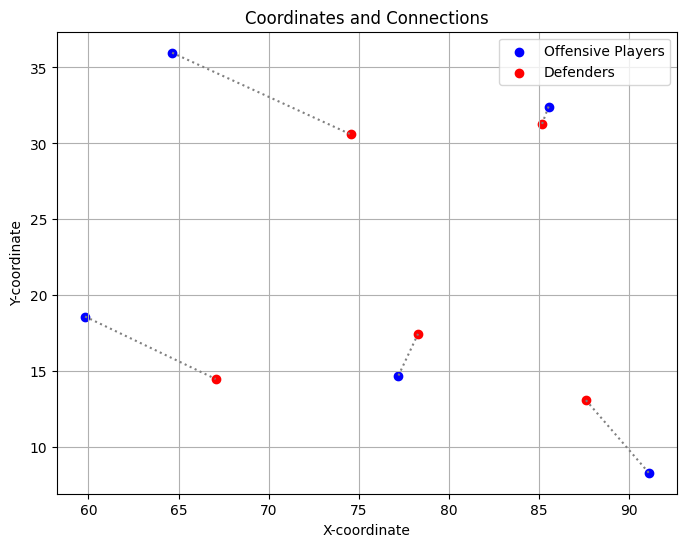

In [224]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(def_training_data[35:40])

# Plotting the coordinates and connecting the pairs of players with lines
plt.figure(figsize=(8, 6))
plt.scatter(df['off_x'], df['off_y'], color='blue', label='Offensive Players')
plt.scatter(df['court_x'], df['court_y'], color='red', label='Defenders')

# Connect the pairs of players with lines
for i, row in df.iterrows():
    plt.plot([row['off_x'], row['court_x']], [row['off_y'], row['court_y']], color='gray', linestyle='dotted')

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Coordinates and Connections')
plt.legend()
plt.grid(True)
plt.show()


##### Now that we know which offensive player each defensive player is responsible for boxing out, there are a host of new ways to develop features based on angles (between pairs of players and the hoop) and distances (from hoop to player and player to player)

Creating features for angles between each pair of players, distances between the pairs, and offensive player's distance to the basket

In [ ]:
# calculating the angle from the offensive player to the defensive player to the hoop
# Calculate the angles in radians
def_training_data['angle_def_to_hoop'] = np.arctan2(def_training_data['court_y'] - def_training_data['which_hoop'], def_training_data['court_x'])
def_training_data['angle_def_to_off'] = np.arctan2(df['off_y'] - def_training_data['court_y'], def_training_data['off_x'] - def_training_data['court_x'])

# Convert angles from radians to degrees if desired
def_training_data['angle_def_to_hoop'] = np.degrees(def_training_data['angle_def_to_hoop'])
def_training_data['angle_def_to_off'] = np.degrees(def_training_data['angle_def_to_off'])

# Normalize angles to [0, 360] degrees for better interpretation
def_training_data['angle_def_to_hoop'] = (def_training_data['angle_def_to_hoop'] + 360) % 360
def_training_data['angle_def_to_off'] = (def_training_data['angle_def_to_off'] + 360) % 360

In [229]:
def_training_data.drop(columns=['angle_def_to_hoop', 'angle_def_to_off'], inplace=True)

C:\Users\timse\AppData\Local\Temp\ipykernel_20052\1343872799.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
def_training_data['hoop_x'] = def_training_data['which_hoop'].apply(lambda x: 90 if x == 1 else 0)
def_training_data['hoop_y'] = 4

In [ ]:
def_training_data.drop(columns='assigned_annotation_code', inplace=True)

In [235]:
def_training_data

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,off_x,off_y,hoop_x,hoop_y
0,2-2,72.807686,37.409669,d1,0,0,1.0,69.994331,39.674616,90,4
1,2-2,79.080643,31.477796,d2,0,0,1.0,82.692421,32.736070,90,4
2,2-2,69.956321,24.467300,d3,0,0,1.0,58.550842,12.962986,90,4
3,2-2,75.468933,13.861763,d4,0,0,1.0,71.667114,12.603488,90,4
4,2-2,84.973496,19.254422,d5,0,0,1.0,81.741959,17.097372,90,4
...,...,...,...,...,...,...,...,...,...,...,...
308040,5020-52,73.893471,11.121111,d1,0,0,1.0,70.669644,7.270347,90,4
308041,5020-52,82.631800,7.270347,d2,0,0,1.0,86.958520,4.382292,90,4
308042,5020-52,68.633583,23.555972,d3,0,0,1.0,58.962087,26.764930,90,4
308043,5020-52,81.613738,21.389860,d4,0,0,1.0,76.777949,20.427222,90,4


In [241]:
import numpy as np
import pandas as pd
import networkx as nx

def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def construct_subgraph(defenders, distances):
    graph = nx.Graph()
    for _, defender_row in defenders.iterrows():
        defender = np.array([defender_row['court_x'], defender_row['court_y']])
        offensive_player = np.array([defender_row['off_x'], defender_row['off_y']])
        hoop = np.array([defender_row['hoop_x'], defender_row['hoop_y']])
        graph.add_edge(tuple(defender), tuple(offensive_player), weight=1.0 / distances[(tuple(defender), tuple(offensive_player))])
        graph.add_edge(tuple(offensive_player), tuple(hoop), weight=1.0 / distances[(tuple(offensive_player), tuple(hoop))])
        graph.add_edge(tuple(defender), tuple(hoop), weight=1.0 / distances[(tuple(defender), tuple(hoop))])
    return graph

# Example usage:
defenders = def_training_data.copy()

distances = {}
for _, defender_row in defenders.iterrows():
    
    defender = np.array([defender_row['court_x'], defender_row['court_y']])
    offensive_player = np.array([defender_row['off_x'], defender_row['off_y']])
    hoop = np.array([defender_row['hoop_x'], defender_row['hoop_y']])
    distances[(tuple(defender), tuple(offensive_player))] = calculate_distance(defender, offensive_player)
    distances[(tuple(offensive_player), tuple(hoop))] = calculate_distance(offensive_player, tuple(hoop))
    distances[(tuple(defender), tuple(hoop))] = calculate_distance(defender, tuple(hoop))

subgraph = construct_subgraph(defenders, distances)

# Now you have a subgraph containing edges only between the defender and the offensive player they are assigned to box out, as well as edges between each player and the hoop.


In [245]:
len(subgraph)

289593

In [ ]:
import matplotlib.pyplot as plt

# Draw the graph
pos = nx.spring_layout(subgraph)  # You can choose other layout algorithms as well

plt.figure(figsize=(10, 10))
nx.draw(subgraph, pos, with_labels=True, node_size=500, font_size=10, font_color='black', node_color='lightblue', edge_color='gray', width=1.0)

# You can add edge weights if you want to display them on the graph
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red')

plt.show()


In [250]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader

c:\Python310\lib\site-packages\torch_geometric\datasets\qm9.py:20: UserWarning:

Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem . (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:84.)



In [251]:
# Create a new DataFrame to aggregate features for each unique offensive player
X_data = def_training_data.groupby('id').agg({
    'court_x': list,    # List of defender's x-coordinates
    'court_y': list,    # List of defender's y-coordinates
    'off_x': list,    # List of offensive player's x-coordinates
    'off_y': list,    # List of offensive player's y-coordinates
    'hoop_x': 'first',  # Hoop x-coordinate (assuming it's the same for each offensive player)
    'hoop_y': 'first',  # Hoop y-coordinate (assuming it's the same for each offensive player)
}).reset_index()

# Convert 'def_x' and 'def_y' lists to arrays
X_data['court_x'] = X_data['court_x'].apply(np.array)
X_data['court_y'] = X_data['court_y'].apply(np.array)
# Convert 'off_x' and 'off_y' lists to arrays
X_data['off_x'] = X_data['off_x'].apply(np.array)
X_data['off_y'] = X_data['off_y'].apply(np.array)

# Convert DataFrame columns to PyTorch tensors
X_def = torch.tensor(X_data[['court_x', 'court_y']].values, dtype=torch.float)
X_off = torch.tensor(X_data[['off_x', 'off_y']].values, dtype=torch.float)
X_hoop = torch.tensor(X_data[['hoop_x', 'hoop_y']].values, dtype=torch.float)
y = torch.tensor(train_pbp['is_oreb'].values, dtype=torch.float)

# Create a PyG Data object for each unique offensive player
data_list = []
for i in range(len(X_data)):
    data = Data(x_def=X_def[i], x_off=X_off[i], x_hoop=X_hoop[i], y=y[i])
    data_list.append(data)

# Create DataLoader object for batch processing
batch_size = 1
train_loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)

c:\Python310\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



In [255]:
X_data

,id,court_x,court_y,off_x,off_y,hoop_x,hoop_y
0,10-10,"[16.7570171722999, 20.1722201934228, 13.667048...","[22.5356046970074, 25.3037507717426, 22.228053...","[18.5459098082322, 28.3037014374366, 27.490581...","[21.1515298256507, 32.0703799907978, 13.615926...",0,4
1,10-12,"[7.22907545016362, 7.03859710693359, 9.3242674...","[27.8739415682279, 24.4516336000883, 15.625814...","[7.99091814114497, 18.8481216430664, 7.2290754...","[26.072725882897, 15.2655711540809, 4.27829302...",0,4
2,10-13,"[26.0280722838182, 8.84929081109854, 14.908529...","[18.4184441199669, 11.836955180535, 19.5798745...","[25.880695269658, 6.06533525540279, 21.6228256...","[12.4563941588769, 3.31976986848391, 28.406847...",0,4
3,10-3,"[77.5726623535156, 81.4388885498047, 73.464607...","[6.72234434347886, 18.1476501318125, 20.432672...","[76.7274994483361, 82.0443741725041, 64.279844...","[4.43749977992131, 15.2916669845581, 26.486110...",90,4
4,10-6,"[72.944519336407, 59.988685461191, 81.95725264...","[19.8130295826839, 22.2100147834191, 16.483833...","[68.5789338625394, 65.6216429196871, 85.618659...","[6.09686970710754, 19.4135207396287, 3.6998155...",90,4
...,...,...,...,...,...,...,...
30800,998-6,"[87.2384416140043, 74.3104322873629, 88.084121...","[29.2301434736985, 29.9157032599816, 19.632908...","[87.1175306760348, 66.0944671630859, 87.600898...","[31.8579783806434, 35.057100882897, 15.5198152...",90,4
30801,999-1,"[19.3360787171584, 23.8065148133498, 8.2204103...","[34.7143540015587, 25.1170525184044, 33.000557...","[21.6317177552443, 31.6600264035738, 4.1124281...","[40.1984985058124, 25.6883401137132, 45.796849...",0,4
30802,999-3,"[12.2751064667335, 6.34431169583247, 17.065397...","[24.2911778963529, 30.7623973259559, 32.703722...","[10.4502134506519, 8.16913316800044, 28.014684...","[16.9571931545551, 25.3697376984816, 35.292221...",0,4
30803,999-4,"[7.41639896539541, 8.55697444769052, 22.243457...","[26.2110049907978, 20.1712369918823, 26.858113...","[9.69747924804688, 9.92560865328862, 30.455406...","[27.9366053067721, 12.6215274517353, 17.367010...",0,4


In [256]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader

# Define your custom Graph Convolutional layer
class GraphConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels))
        self.bias = nn.Parameter(torch.Tensor(out_channels))
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x, edge_index):
        x = F.linear(x, self.weight, self.bias)
        # Perform aggregation or other operations if needed
        return x

# Define your GNN model
class MyGNNModel(nn.Module):
    def __init__(self, num_input_features, num_output_channels):
        super(MyGNNModel, self).__init__()
        # Assuming you have 1 convolutional layer in this example
        self.conv1 = GraphConvolution(num_input_features, num_output_channels)

    def forward(self, data):
        # Extract input features
        x_def = data.x_def  # Assuming shape (batch_size, num_input_features)
        edge_index = data.edge_index  # Define edge_index based on your graph structure
        
        # Perform graph convolutions
        x_def = self.conv1(x_def, edge_index)
        # Perform other operations or aggregations if needed

        return x_def

# Assuming you have prepared the DataLoader as 'train_loader'
# Initialize your GNN model
num_input_features = 5  # Change this to the actual number of input features in x_def
num_output_channels = 16  # You can adjust this based on your desired output channels
model = MyGNNModel(num_input_features, num_output_channels)

# Training loop
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Use your preferred optimizer

num_epochs = 10  # Adjust the number of epochs as needed
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Evaluation (you can use a separate validation DataLoader)
model.eval()
# Perform evaluation on validation data and calculate metrics
# For example, you can use ROC-AUC, accuracy, etc. for evaluation


ValueError: Target size (torch.Size([])) must be the same as input size (torch.Size([2, 16]))

#### Creating image like matrices
- Representing the player positions on the court
- This approach is suitable for preparing the data to be used in a CNN

In [24]:
def create_court_grid(court_width, court_height):
    """
    Create an empty court grid with higher resolution and multiple channels for each play.

    Parameters
    ----------
    court_width : int
        The width of the court grid in the desired higher resolution. For example, the width in inches or centimeters.

    court_height : int
        The height of the court grid in the desired higher resolution. For example, the height in inches or centimeters.

    Returns
    -------
    numpy.ndarray
        A 3D NumPy array representing the court grid with high resolution and three channels.
        The dimensions of the array are (court_height, court_width, 3),
        where the three channels represent shooter, offense, and defense.

    Examples
    --------
    >>> court_width_inches = 500
    >>> court_height_inches = 940
    >>> grid = create_court_grid(court_width_inches, court_height_inches)
    >>> print(grid.shape)
    (940, 500, 3)
    """
    return np.zeros((court_height, court_width, 4))



def place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height):
    """
    Place player positions on the court grid with higher resolution and channels for shooter, offense, and defense.

    Parameters
    ----------
    court_grid : numpy.ndarray
        A 3D NumPy array representing the court grid with higher resolution and three channels.
        The array has dimensions (court_height_inches, court_width_inches, 3), where the three channels
        represent shooter, offense, and defense.

    player_positions : numpy.ndarray
        A 2D NumPy array containing the X and Y coordinates of the player positions.

    shooter_index : int
        The index of the shooter in the player_positions array.

    offense_indices : list
        A list of indices representing the players on offense in the player_positions array.

    defense_indices : list
        A list of indices representing the players on defense in the player_positions array.

    coordinate_multiplier : float
        The multiplier to convert the player positions from feet to the desired higher resolution (e.g., inches).

    Returns
    -------
    None
        This function modifies the court_grid in place, updating the shooter, offense, and defense channels
        based on the player_positions and corresponding indices.
    """
    for i, (x, y) in enumerate(player_positions):
        x_dist = x * coordinate_multiplier
        y_dist = y * coordinate_multiplier
        if 0 <= x_dist < court_width and 0 <= y_dist < court_height:
            # finding the index of the shooter
            if i == np.argmax(shooter_index):
                court_grid[int(y_dist)][int(x_dist)][0] = 1  # Shooter channel
            # finding the indices of offensive players and comparing to the index
            if i in np.where(offense_indices == 1)[0]:
                court_grid[int(y_dist)][int(x_dist)][1] = 1  # Offense channel
            if i in np.where(defense_indices == 1)[0]:
                court_grid[int(y_dist)][int(x_dist)][2] = 1  # Defense channel
    return court_grid

In [25]:
# Define the dimensions of the court grid with high resolution
# Depending on runtime, using lower resolution images may be a better approach here, but let's start with inches

coordinate_multiplier = 1
court_width = 94 * coordinate_multiplier
court_height = 50 * coordinate_multiplier

# Derive parameters from the data table
player_positions_train = training_data[['court_x', 'court_y']].values
shooter_indices_train = training_data['shooter'].values
offense_indices_train = training_data['offense'].values
defense_indices_train = training_data['offense'].apply(lambda x: 0 if x == 1 else 1).values # Complement of 'offense' column gives 'defense' indices
which_hoop_train = training_data['which_hoop'].values

In [28]:
# Derive parameters from the data table
player_positions_test = testing_data[['court_x', 'court_y']].values
shooter_indices_test = testing_data['shooter'].values
offense_indices_test = testing_data['offense'].values
defense_indices_test = testing_data['offense'].apply(lambda x: 0 if x == 1 else 1).values # Complement of 'offense' column gives 'defense' indices
which_hoop_test = testing_data['which_hoop'].values

In [ ]:
# Create image-like training examples with higher resolution and multiple channels
X_train_images = []
# Reshaping organizes the positions into a list of list of coordinates, so there is one training example per play
for index, (player_positions, shooter_index, offense_indices, defense_indices, which_hoop_indices) in enumerate(zip(player_positions_train.reshape(-1, 10, 2), shooter_indices_train.reshape(-1, 10), offense_indices_train.reshape(-1, 10), defense_indices_train.reshape(-1, 10), which_hoop_train.reshape(-1, 10))):
    court_grid = create_court_grid(court_width, court_height)
    place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height)
    which_hoop = which_hoop_indices[0]
    if which_hoop == 0:
        court_grid[25][4][3] = 1 # Basketball hoop channel
    else:
        court_grid[25][90][3] = 1
    X_train_images.append(court_grid)

In [81]:
# Create image-like training examples with higher resolution and multiple channels
X_test_images = []
# Reshaping organizes the positions into a list of list of coordinates, so there is one training example per play
for index, (player_positions, shooter_index, offense_indices, defense_indices, which_hoop_indices) in enumerate(zip(player_positions_test.reshape(-1, 10, 2), shooter_indices_test.reshape(-1, 10), offense_indices_test.reshape(-1, 10), defense_indices_test.reshape(-1, 10), which_hoop_test.reshape(-1, 10))):
    court_grid = create_court_grid(court_width, court_height)
    place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height)
    which_hoop = which_hoop_indices[0]
    if which_hoop == 0:
        court_grid[25][4][3] = 1 # Basketball hoop channel
    else:
        court_grid[25][90][3] = 1
    X_test_images.append(court_grid)

In [82]:
X_train_images = np.array(X_train_images)
X_test_images = np.array(X_test_images)

In [135]:
training_data

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop
0,2-2,72.807686,37.409669,d1,0,0,1.0
1,2-2,79.080643,31.477796,d2,0,0,1.0
2,2-2,69.956321,24.467300,d3,0,0,1.0
3,2-2,75.468933,13.861763,d4,0,0,1.0
4,2-2,84.973496,19.254422,d5,0,0,1.0
...,...,...,...,...,...,...,...
308045,5020-52,70.669644,7.270347,s,1,1,1.0
308046,5020-52,86.958520,4.382292,t1,1,0,1.0
308047,5020-52,58.962087,26.764930,t2,1,0,1.0
308048,5020-52,76.777949,20.427222,t3,1,0,1.0


In [138]:
y_train[y_train == 1].index

Int64Index([    3,     8,    12,    14,    18,    21,    26,    28,    33,
               40,
            ...
            30781, 30783, 30786, 30789, 30794, 30795, 30797, 30801, 30802,
            30803],
           dtype='int64', length=8685)

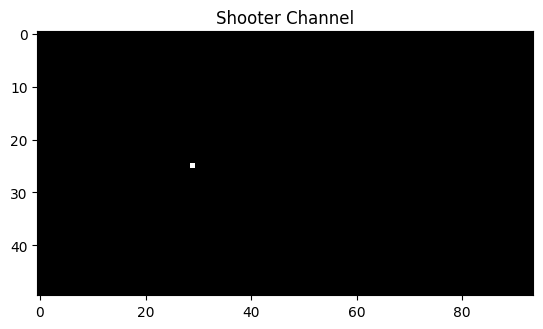

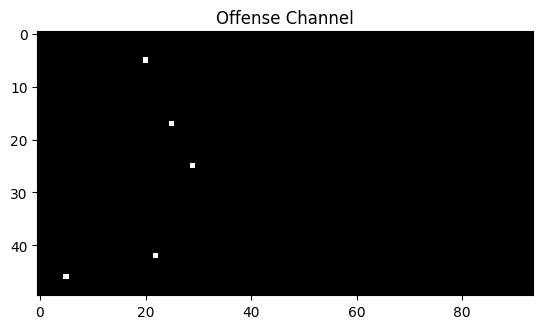

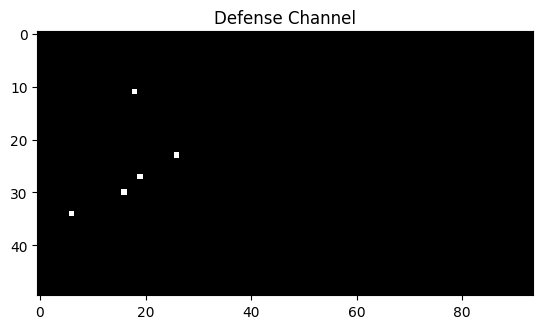

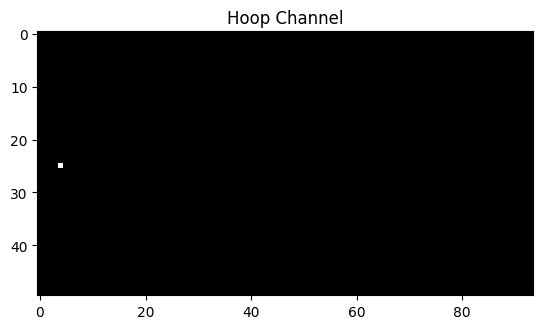

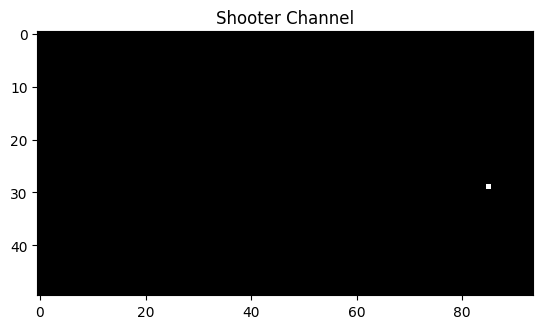

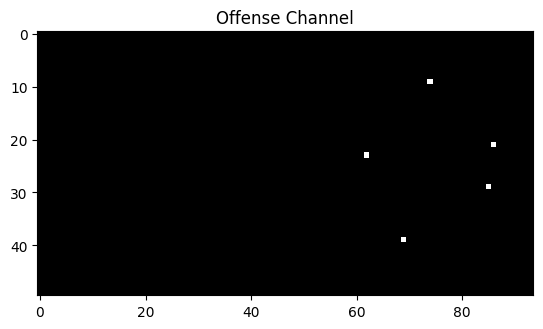

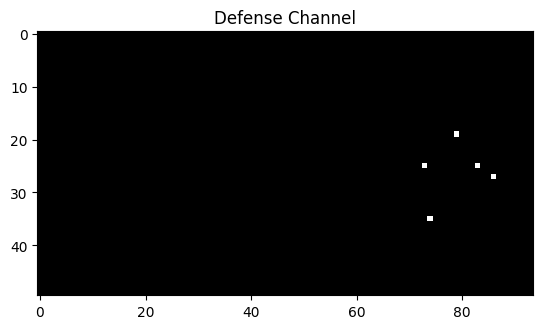

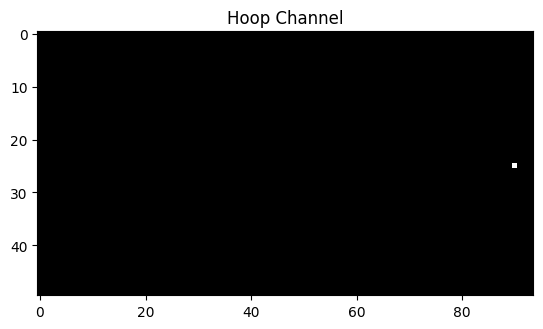

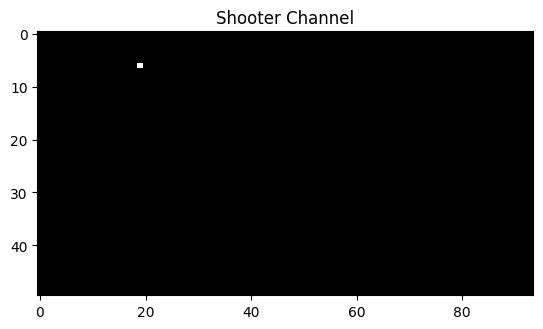

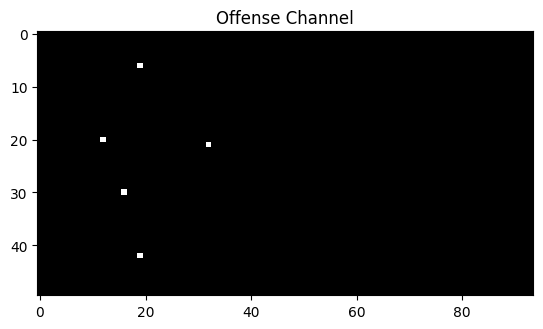

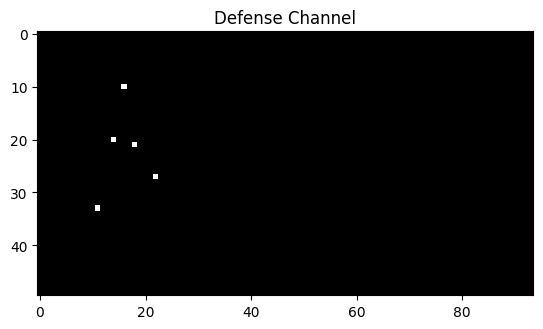

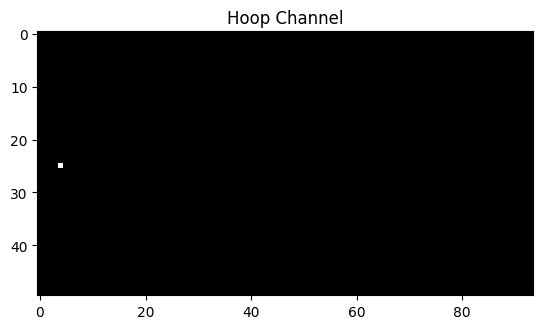

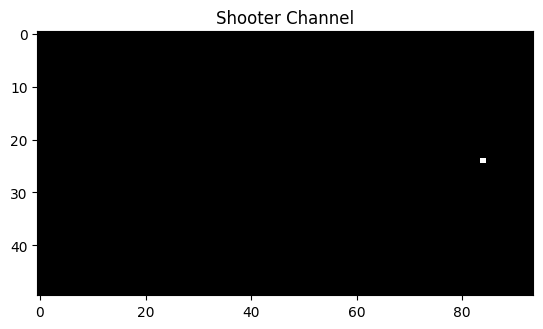

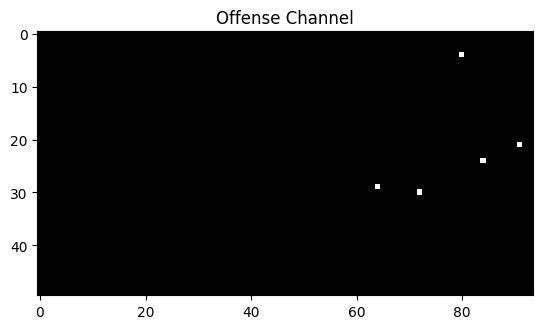

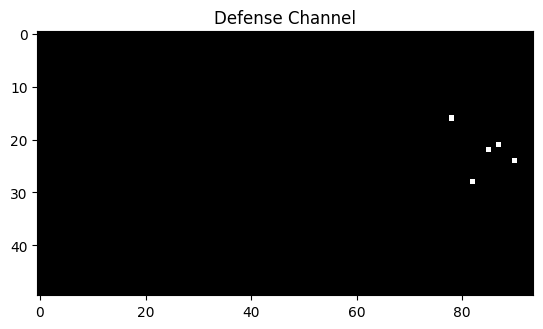

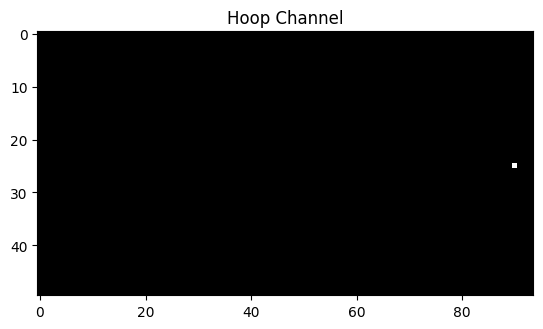

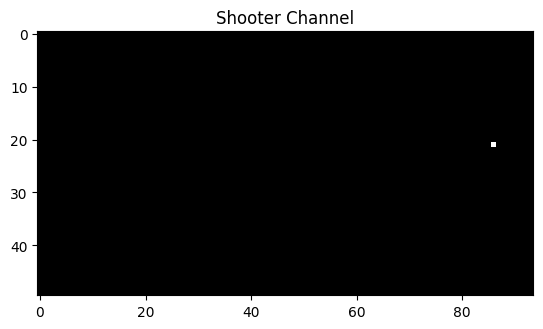

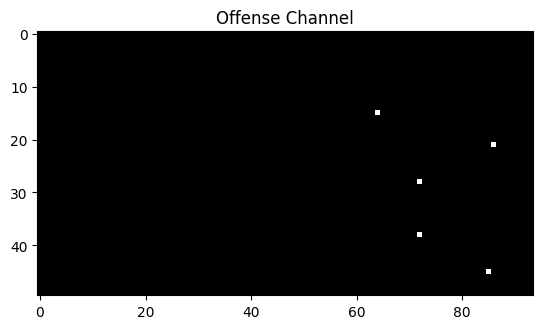

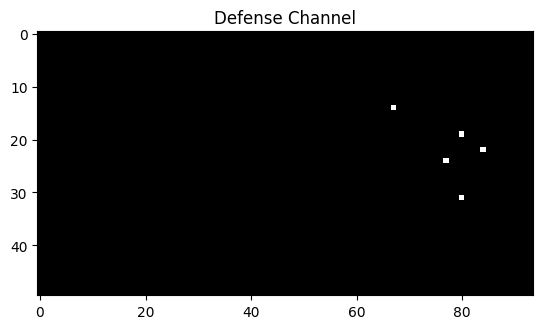

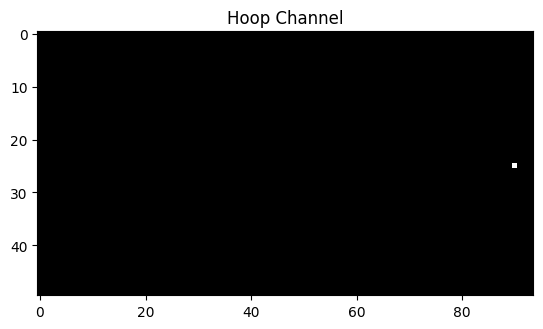

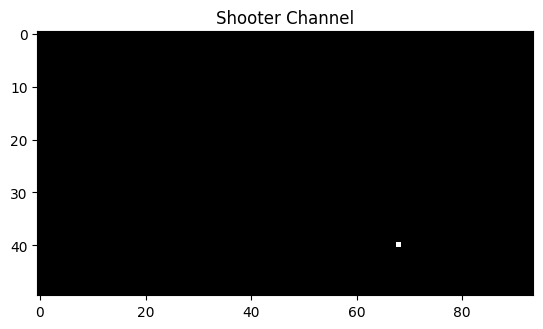

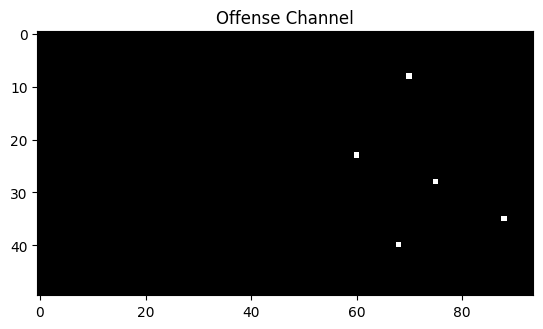

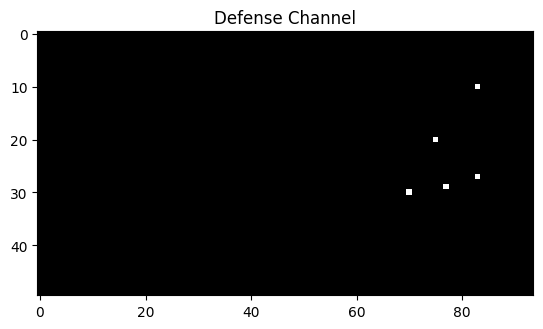

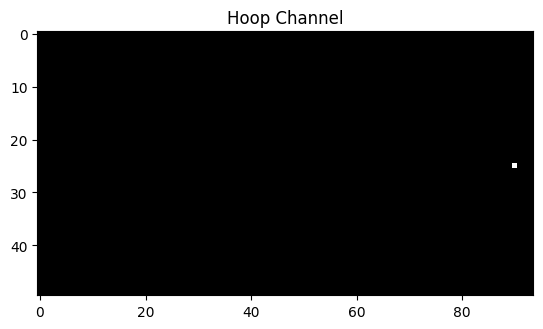

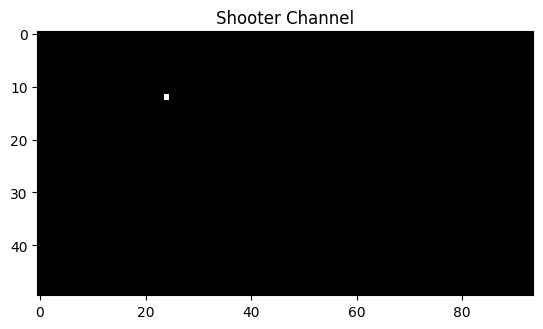

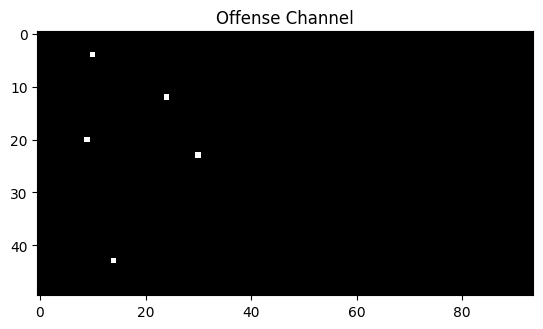

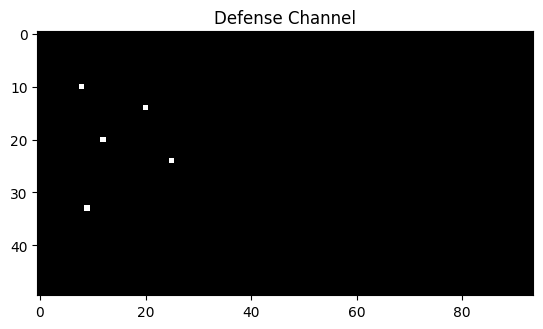

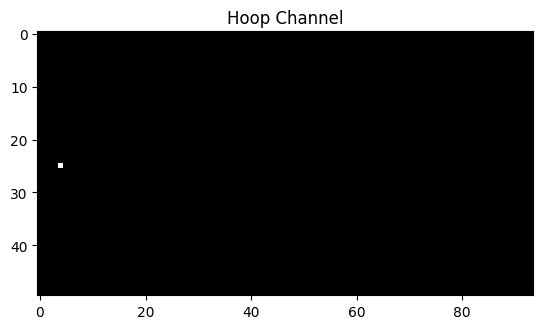

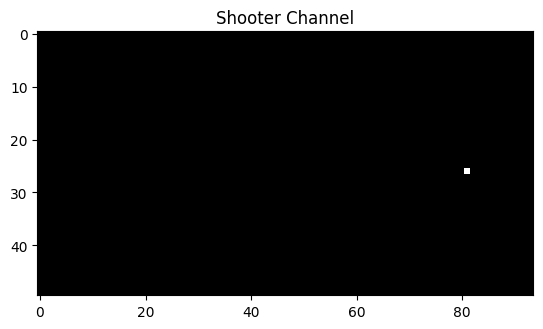

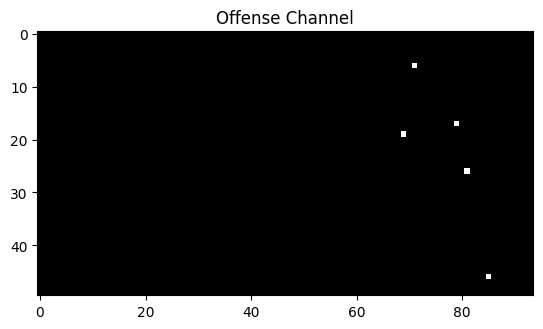

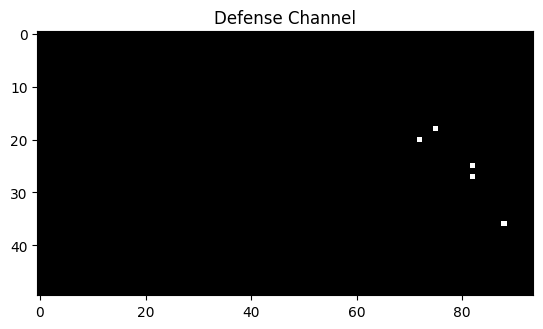

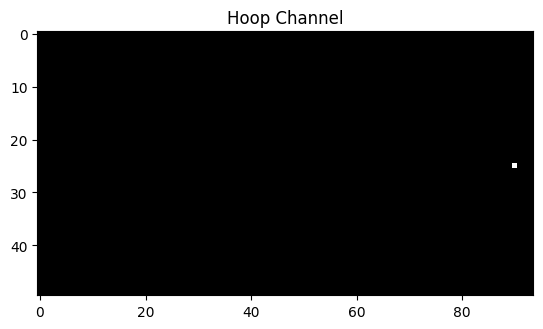

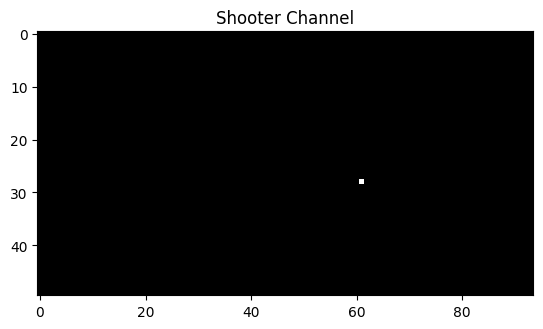

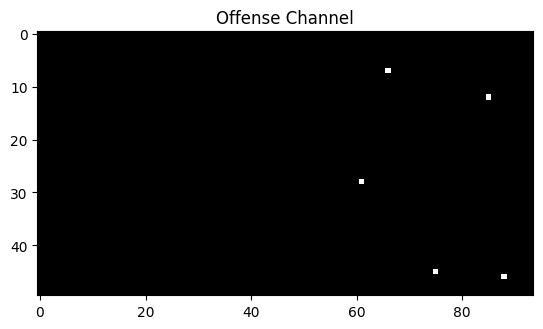

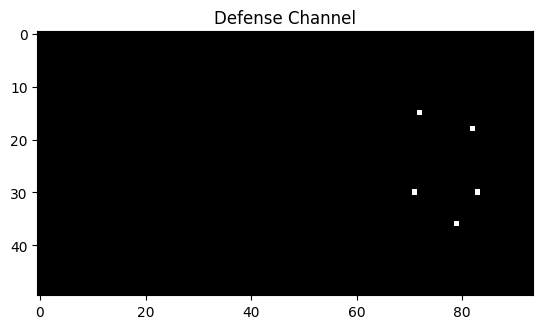

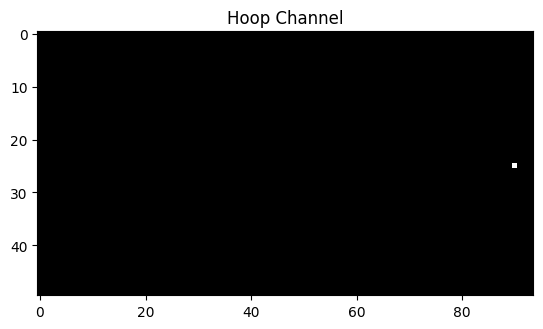

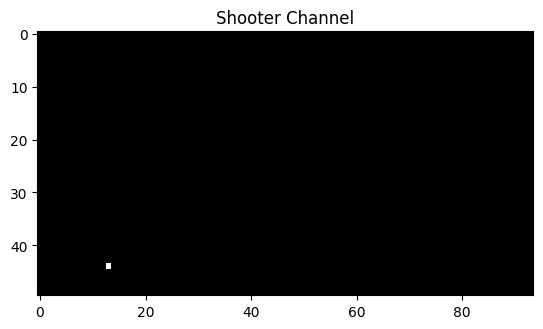

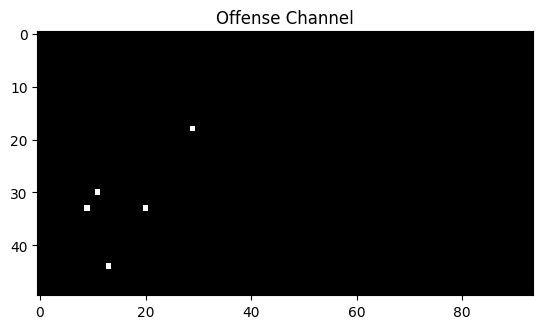

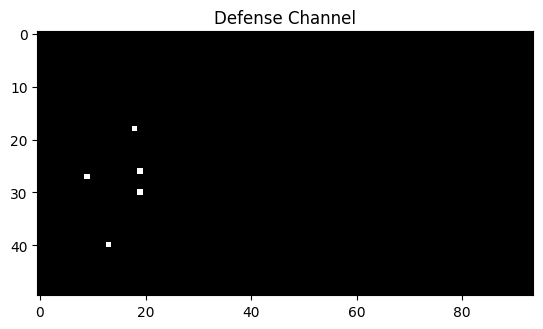

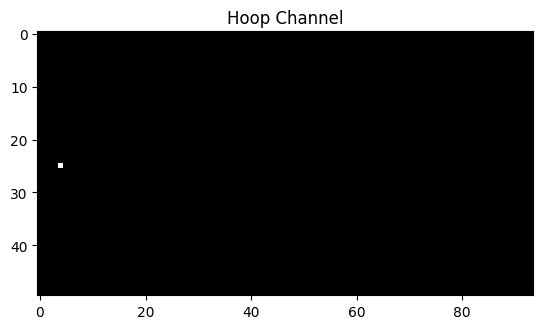

In [139]:
for sample_index in y_train[y_train == 1].index[:10]:
    # Visualize the shooter channel
    plt.imshow(X_test_images[sample_index, :, :, 0], cmap='gray')
    plt.title("Shooter Channel")
    plt.show()

    # Visualize the offense channel
    plt.imshow(X_test_images[sample_index, :, :, 1], cmap='gray')
    plt.title("Offense Channel")
    plt.show()

    # Visualize the defense channel
    plt.imshow(X_test_images[sample_index, :, :, 2], cmap='gray')
    plt.title("Defense Channel")
    plt.show()

    # Visualize the basketball hoop channel
    plt.imshow(X_test_images[sample_index, :, :, 3], cmap='gray')
    plt.title("Hoop Channel")
    plt.show()


In [84]:
y_train = train_pbp['is_oreb']

In [34]:
# Define the file path for saving the data
save_path = 'X_train_images_with_hoop.npz'

# Save the data to the file
np.savez_compressed(save_path, X_train_images=X_train_images)

In [85]:
# Define the file path for saving the data
save_path = 'X_test_images_with_hoop.npz'

# Save the data to the file
np.savez_compressed(save_path, X_test_images=X_test_images)

In [40]:
# Load the data from the file
save_path = 'X_train_images_with_hoop.npz'
loaded_data = np.load(save_path)
X_train_images = loaded_data['X_train_images']

In [51]:
# Load the data from the file
save_path = 'X_test_images_with_hoop.npz'
loaded_data = np.load(save_path)
X_test_images = loaded_data['X_test_images']

In [18]:
# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train_images, y_train, test_size=0.2, random_state=42)

In [16]:
# # Define the CNN model
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(court_height, court_width, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01)))
# model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# # Compile the model with log loss (binary cross-entropy)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# batch_size = 32
# epochs = 10

# history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

# # Evaluate the model
# loss, accuracy = model.evaluate(X_val, y_val)
# print(f"Validation Loss (Log Loss): {loss:.4f}, Validation Accuracy: {accuracy:.4f}")


Epoch 1/10
771/771 [==============================] - 172s 221ms/step - loss: 0.6158 - accuracy: 0.7177 - val_loss: 0.6030 - val_accuracy: 0.7174
Epoch 2/10
771/771 [==============================] - 170s 220ms/step - loss: 0.5956 - accuracy: 0.7182 - val_loss: 0.5974 - val_accuracy: 0.7174
Epoch 3/10
771/771 [==============================] - 172s 223ms/step - loss: 0.5934 - accuracy: 0.7182 - val_loss: 0.5938 - val_accuracy: 0.7174
Epoch 4/10
771/771 [==============================] - 169s 220ms/step - loss: 0.5909 - accuracy: 0.7182 - val_loss: 0.5929 - val_accuracy: 0.7174
Epoch 5/10
771/771 [==============================] - 169s 219ms/step - loss: 0.5898 - accuracy: 0.7182 - val_loss: 0.5914 - val_accuracy: 0.7174
Epoch 6/10
771/771 [==============================] - 180s 233ms/step - loss: 0.5891 - accuracy: 0.7182 - val_loss: 0.5943 - val_accuracy: 0.7174
Epoch 7/10
771/771 [==============================] - 180s 234ms/step - loss: 0.5889 - accuracy: 0.7182 - val_loss: 0.5920 -

In [86]:
shooter_data_train['mean_def_dist'] = def_mean_distances_train.values
shooter_data_test['mean_def_dist'] = def_mean_distances_test.values

C:\Users\timse\AppData\Local\Temp\ipykernel_20052\3554656918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shooter_data_train['mean_def_dist'] = def_mean_distances_train.values
C:\Users\timse\AppData\Local\Temp\ipykernel_20052\3554656918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shooter_data_test['mean_def_dist'] = def_mean_distances_test.values


In [94]:
train_data = shooter_data_train[['mean_def_dist', 'distance_from_hoop']]
test_data = shooter_data_test[['mean_def_dist', 'distance_from_hoop']]

In [107]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

# Assuming you have already preprocessed your data and created X (features) and y (target)
# X should contain both the image data (X_train_img) and statistical features (X_train_)

# Split the data into training and validation sets
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_train_data, y_train, test_size=0.2, random_state=42)

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, random_state=42)

# Train the model
xgb_model.fit(X_train_b, y_train_b)

# Predict probabilities on the validation set
y_pred_prob = xgb_model.predict_proba(X_val_b)

# Predict on the validation set
y_pred = xgb_model.predict(X_val_b)

# Calculate log loss
log_loss_val = log_loss(y_val_b, y_pred_prob)

# Evaluate the model
accuracy = accuracy_score(y_val_b, y_pred)
conf_matrix = confusion_matrix(y_val_b, y_pred)
classification_rep = classification_report(y_val_b, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("Log Loss:", log_loss_val)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)


Accuracy: 0.7107612400584321
Log Loss: 0.6078854756297489
Confusion Matrix:
[[4336   84]
 [1698   43]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      4420
           1       0.34      0.02      0.05      1741

    accuracy                           0.71      6161
   macro avg       0.53      0.50      0.44      6161
weighted avg       0.61      0.71      0.61      6161



In [106]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming you have already preprocessed your data and created X (features) and y (target)
# X should contain both the image data (X_train_img) and statistical features (X_train_)

# Split the data into training and validation sets
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_train_data, y_train, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rfc.fit(X_train_b, y_train_b)
# Predict probabilities on the validation set
y_pred_prob = rfc.predict_proba(X_val_b)

# Predict on the validation set
y_pred = rfc.predict(X_val_b)

# Calculate log loss
log_loss_val = log_loss(y_val_b, y_pred_prob)

# Evaluate the model
accuracy = accuracy_score(y_val_b, y_pred)
conf_matrix = confusion_matrix(y_val_b, y_pred)
classification_rep = classification_report(y_val_b, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("Log Loss:", log_loss_val)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.6576854406752151
Log Loss: 0.7270243802463741
Confusion Matrix:
[[3821  599]
 [1510  231]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78      4420
           1       0.28      0.13      0.18      1741

    accuracy                           0.66      6161
   macro avg       0.50      0.50      0.48      6161
weighted avg       0.59      0.66      0.61      6161



In [95]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [97]:
train_data

array([[-0.14001929,  0.90105778],
       [-0.87338449,  0.05711044],
       [ 0.0945783 ,  0.51343901],
       ...,
       [-0.40835585, -1.03975593],
       [ 0.32436571,  1.46207924],
       [ 0.3233901 ,  1.06512511]])

In [99]:
# Reshape the rebound percentage features to (num_samples, 1) to match the image data
X_train_data = train_data

# Split the data into training and validation sets
X_train_img, X_val_img, y_tr, y_val = train_test_split(X_train_images, y_train, test_size=0.2, random_state=42)
X_train_, X_val_, _, _ = train_test_split(X_train_data, y_train, test_size=0.2, random_state=42)

In [101]:
# Print the shapes of input data
print("Shape of X_train_img:", X_train_img.shape)
print("Shape of X_train_:", X_train_.shape)
print("Shape of X_val_img:", X_val_img.shape)
print("Shape of X_val_:", X_val_.shape)
print("Shape of y_tr:", y_tr.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train_img: (24644, 50, 94, 4)
Shape of X_train_: (24644, 2)
Shape of X_val_img: (6161, 50, 94, 4)
Shape of X_val_: (6161, 2)
Shape of y_tr: (24644,)
Shape of y_val: (6161,)


In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_images, y_train, test_size=0.2, random_state=42)

In [ ]:
# Define the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(court_height, court_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01)))
model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model with log loss (binary cross-entropy)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss (Log Loss): {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

Model Architecture:

- CNN Model for Image Data:
    - Input shape: (court_height, court_width, 4) (Assuming 4 channels for the image data)
    - Conv2D Layers: 3 layers with 32, 64, and 128 filters and 'relu' activation
    - MaxPooling2D Layers: Applied after each Conv2D layer with (2, 2) pool size
    - Flatten Layer: Flattens the output of the last MaxPooling2D layer
    - Dense Layer: 256 neurons with 'relu' activation and L2 regularization (lambda = 0.01)
    - Dropout Layer: Dropout rate of 0.5 applied after the Dense layer
- Input Layer for Rebound Percentage Features:
    - Input shape: (2,)
- Concatenation:
    - Concatenates the outputs from the two branches (CNN model and rebound percentage features)
- Output Layer:
    - Dense layer with 1 neuron and 'sigmoid' activation
Model Performance:

Epochs: 10
Batch Size: 32
Training Time: Approximately 10 minutes per epoch
Validation Log Loss: 0.5925
Validation Accuracy: 0.7174

In [126]:
# Define the CNN model for image data
input_img = Input(shape=(court_height, court_width, 4))  # Assuming 3 channels for the image data
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
x = Dropout(0.5)(x)

input_rebounds = Input(shape=(2,)) 

# Concatenate the outputs from the two branches
combined = Concatenate()([x, input_rebounds])
output = Dense(1, activation='sigmoid')(combined)

# Create the multi-modal model
model = Model(inputs=[input_img, input_rebounds], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit([X_train_img, X_train_], y_tr, batch_size=batch_size, epochs=epochs, validation_data=([X_val_img, X_val_], y_val))

# Evaluate the model on the validation set
val_predictions = model.predict([X_val_img, X_val_])

val_loss = log_loss(y_val, val_predictions.flatten())
val_accuracy = np.mean((val_predictions.flatten() > 0.5) == y_val)

# Print the results
print(f"Validation Log Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Epoch 1/10
771/771 [==============================] - 62s 79ms/step - loss: 0.6307 - accuracy: 0.7166 - val_loss: 0.6024 - val_accuracy: 0.7174
Epoch 2/10
771/771 [==============================] - 64s 83ms/step - loss: 0.5996 - accuracy: 0.7182 - val_loss: 0.5973 - val_accuracy: 0.7174
Epoch 3/10
771/771 [==============================] - 65s 84ms/step - loss: 0.5964 - accuracy: 0.7182 - val_loss: 0.5977 - val_accuracy: 0.7174
Epoch 4/10
771/771 [==============================] - 70s 91ms/step - loss: 0.5950 - accuracy: 0.7182 - val_loss: 0.5953 - val_accuracy: 0.7174
Epoch 5/10
771/771 [==============================] - 76s 98ms/step - loss: 0.5932 - accuracy: 0.7182 - val_loss: 0.5956 - val_accuracy: 0.7174
Epoch 6/10
771/771 [==============================] - 76s 98ms/step - loss: 0.5927 - accuracy: 0.7182 - val_loss: 0.5937 - val_accuracy: 0.7174
Epoch 7/10
771/771 [==============================] - 80s 104ms/step - loss: 0.5888 - accuracy: 0.7182 - val_loss: 0.5917 - val_accuracy

In [125]:
# Define the CNN model for image data
input_img = Input(shape=(court_height, court_width, 4))  # Assuming 3 channels for the image data
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
# x = Conv2D(128, (3, 3), activation='relu')(x)
# x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
x = Dropout(0.5)(x)

input_rebounds = Input(shape=(2,)) 

# Concatenate the outputs from the two branches
combined = Concatenate()([x, input_rebounds])
output = Dense(1, activation='sigmoid')(combined)

# Create the multi-modal model
model = Model(inputs=[input_img, input_rebounds], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit([X_train_img, X_train_], y_tr, batch_size=batch_size, epochs=epochs, validation_data=([X_val_img, X_val_], y_val))

# Evaluate the model on the validation set
val_predictions = model.predict([X_val_img, X_val_])

val_loss = log_loss(y_val, val_predictions.flatten())
val_accuracy = np.mean((val_predictions.flatten() > 0.5) == y_val)

# Print the results
print(f"Validation Log Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Epoch 1/10
771/771 [==============================] - 60s 76ms/step - loss: 0.6303 - accuracy: 0.7171 - val_loss: 0.6130 - val_accuracy: 0.7174
Epoch 2/10
771/771 [==============================] - 56s 73ms/step - loss: 0.6054 - accuracy: 0.7182 - val_loss: 0.6011 - val_accuracy: 0.7174
Epoch 3/10
771/771 [==============================] - 57s 74ms/step - loss: 0.5988 - accuracy: 0.7182 - val_loss: 0.5962 - val_accuracy: 0.7174
Epoch 4/10
771/771 [==============================] - 58s 75ms/step - loss: 0.5953 - accuracy: 0.7182 - val_loss: 0.5990 - val_accuracy: 0.7174
Epoch 5/10
771/771 [==============================] - 63s 81ms/step - loss: 0.5935 - accuracy: 0.7182 - val_loss: 0.5922 - val_accuracy: 0.7174
Epoch 6/10
771/771 [==============================] - 61s 79ms/step - loss: 0.5936 - accuracy: 0.7182 - val_loss: 0.5963 - val_accuracy: 0.7174
Epoch 7/10
771/771 [==============================] - 62s 81ms/step - loss: 0.5934 - accuracy: 0.7182 - val_loss: 0.5931 - val_accuracy:

In [116]:
X_train_img.shape, X_train_.shape

((24644, 50, 94, 4), (24644, 2))

In [134]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from sklearn.metrics import make_scorer, log_loss

# Define the CNN model as a function
def create_model(learning_rate=0.001, dropout_rate=0.5, dense_units=128, include_last_conv_layer=True):
    input_img = Input(shape=(court_height, court_width, 4))
    x = Conv2D(32, (3, 3), activation='relu')(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    if include_last_conv_layer:
        x = Conv2D(128, (3, 3), activation='relu')(x)
        x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)

    
    model = Model(inputs=[input_img], outputs=output)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create KerasClassifier wrapper for scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameter grid for the randomized search
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],
    'dense_units': [64, 128, 256],
    'include_last_conv_layer': [True, False]
}

# Define log loss as the scoring metric
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(model, param_distributions=param_grid, scoring=log_loss_scorer, n_iter=5, cv=3, verbose=3)

random_search_results = random_search.fit(X_train_img, y_tr)

# Print the best hyperparameters and log loss score
print("Best Hyperparameters:", random_search_results.best_params_)
print("Best Log Loss:", -random_search_results.best_score_)


C:\Users\timse\AppData\Local\Temp\ipykernel_20052\3079426148.py:32: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
257/257 [==============================] - 6s 22ms/step
[CV 1/3] END dense_units=128, dropout_rate=0.5, include_last_conv_layer=True, learning_rate=0.1;, score=-0.591 total time=  49.5s
257/257 [==============================] - 6s 22ms/step
[CV 2/3] END dense_units=128, dropout_rate=0.5, include_last_conv_layer=True, learning_rate=0.1;, score=-0.596 total time=  53.2s
257/257 [==============================] - 6s 24ms/step
[CV 3/3] END dense_units=128, dropout_rate=0.5, include_last_conv_layer=True, learning_rate=0.1;, score=-0.598 total time=  52.8s
257/257 [==============================] - 6s 23ms/step
[CV 1/3] END dense_units=256, dropout_rate=0.4, include_last_conv_layer=False, learning_rate=0.1;, score=-0.592 total time=  56.8s
257/257 [==============================] - 5s 20ms/step
[CV 2/3] END dense_units=256, dropout_rate=0.4, include_last_conv_layer=False, learning_rate=0.1;, score=-0.596 total time=  55.5s
257/257 

In [131]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
from sklearn.metrics import make_scorer, log_loss
from bayes_opt import BayesianOptimization

# Define the CNN model as a function
def create_model(learning_rate, dropout_rate, dense_units, include_last_conv_layer):
    # Your model architecture here, as defined earlier

# Define the bounds for hyperparameters
pbounds = {
    'learning_rate': (0.001, 0.1),
    'dropout_rate': (0.2, 0.5),
    'dense_units': (64, 256),
    'include_last_conv_layer': (0, 1)
}

# Define log loss as the objective function to minimize
def objective(learning_rate, dropout_rate, dense_units, include_last_conv_layer):
    model = create_model(learning_rate, dropout_rate, int(dense_units), bool(include_last_conv_layer))
    model.fit([X_train_img, X_train_], y_tr, epochs=10, batch_size=32, verbose=0)
    val_predictions = model.predict([X_val_img, X_val_])
    val_loss = log_loss(y_val, val_predictions.flatten())
    return val_loss

# Perform Bayesian optimization
optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=5)

# Get the best hyperparameters and log loss score
best_params = optimizer.max['params']
best_log_loss = -optimizer.max['target']
print("Best Hyperparameters:", best_params)
print("Best Log Loss:", best_log_loss)


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python310\python.exe -m pip install --upgrade pip' command.


In [109]:
conf_matrix = confusion_matrix(y_val, (val_predictions.flatten() > 0.5))

In [110]:
conf_matrix

array([[4420,    0],
       [1741,    0]], dtype=int64)

In [111]:
val_predictions

array([[0.20548178],
       [0.2878199 ],
       [0.23514229],
       ...,
       [0.35730284],
       [0.3443506 ],
       [0.26466092]], dtype=float32)

In [167]:
# Define the CNN model for image data
input_img = Input(shape=(court_height, court_width, 3))  # Assuming 3 channels for the image data
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
x = Dropout(0.5)(x)

# Define the input layer for rebound percentage features
input_rebounds = Input(shape=(2,))  # Assuming 1 feature for rebound percentages

# Concatenate the outputs from the two branches
combined = Concatenate()([x, input_rebounds])
output = Dense(1, activation='sigmoid')(combined)

# Create the multi-modal model
model = Model(inputs=[input_img, input_rebounds], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit([X_train_img, X_train_rebounds], y_tr, batch_size=batch_size, epochs=epochs, validation_data=([X_val_img, X_val_rebounds], y_val))

# Evaluate the model on the validation set
val_predictions = model.predict([X_val_img, X_val_rebounds])
val_loss = log_loss(y_val, val_predictions)
val_accuracy = np.mean((val_predictions > 0.5) == y_val)

# Print the results
print(f"Validation Log Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Epoch 1/10
771/771 [==============================] - 70s 89ms/step - loss: 0.6724 - accuracy: 0.7176 - val_loss: 0.6003 - val_accuracy: 0.7174
Epoch 2/10
771/771 [==============================] - 71s 92ms/step - loss: 0.5996 - accuracy: 0.7182 - val_loss: 0.5989 - val_accuracy: 0.7174
Epoch 3/10
771/771 [==============================] - 69s 90ms/step - loss: 0.5979 - accuracy: 0.7182 - val_loss: 0.5951 - val_accuracy: 0.7174
Epoch 4/10
771/771 [==============================] - 68s 89ms/step - loss: 0.5936 - accuracy: 0.7182 - val_loss: 0.5938 - val_accuracy: 0.7174
Epoch 5/10
771/771 [==============================] - 74s 96ms/step - loss: 0.5904 - accuracy: 0.7182 - val_loss: 0.5881 - val_accuracy: 0.7174
Epoch 6/10
771/771 [==============================] - 73s 94ms/step - loss: 0.5873 - accuracy: 0.7182 - val_loss: 0.5879 - val_accuracy: 0.7174
Epoch 7/10
771/771 [==============================] - 75s 98ms/step - loss: 0.5854 - accuracy: 0.7182 - val_loss: 0.5860 - val_accuracy:

C:\Users\timse\AppData\Local\Temp\ipykernel_16216\2900417551.py:34: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



ValueError: Data must be 1-dimensional

In [1]:
val_predictions.flatten()

NameError: name 'val_predictions' is not defined

In [168]:
val_loss = log_loss(y_val, val_predictions.flatten())
val_accuracy = np.mean((val_predictions.flatten() > 0.5) == y_val)

# Print the results
print(f"Validation Log Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Validation Log Loss: 0.5820042970390139
Validation Accuracy: 0.7175783152085701


In [ ]:
pd.set_option('display.max_rows', 10)

In [ ]:
train_pbp['team'].value_counts()

Duke                 1432
Kentucky              963
Alabama               758
Auburn                757
Arizona               750
                     ... 
Bradley                 9
Texas Southern          9
Belmont                 9
Southern Illinois       9
Utah Valley             6
Name: team, Length: 160, dtype: int64

Thoughts:
- tendencies to get back on defense may determine how often there is an offensive rebound - past offensive rebounding performance by team may be helpful
- spacing
- strength of the team / athleticisim of the players may be informed by conference

In [ ]:
training_data

,id,court_x,court_y,annotation_code,is_oreb,team,opponent,conference,opp_conference
0,2-2,72.807686,37.409669,d1,0,Kentucky,Duke,SEC,ACC
1,2-2,79.080643,31.477796,d2,0,Kentucky,Duke,SEC,ACC
2,2-2,69.956321,24.467300,d3,0,Kentucky,Duke,SEC,ACC
3,2-2,75.468933,13.861763,d4,0,Kentucky,Duke,SEC,ACC
4,2-2,84.973496,19.254422,d5,0,Kentucky,Duke,SEC,ACC
...,...,...,...,...,...,...,...,...,...
308045,5020-52,70.669644,7.270347,s,0,San Diego St.,Connecticut,MWC,BigEast
308046,5020-52,86.958520,4.382292,t1,0,San Diego St.,Connecticut,MWC,BigEast
308047,5020-52,58.962087,26.764930,t2,0,San Diego St.,Connecticut,MWC,BigEast
308048,5020-52,76.777949,20.427222,t3,0,San Diego St.,Connecticut,MWC,BigEast


In [ ]:
X_train = training_data[['court_x', 'court_y', 'annotation_code']]
X_test = testing_data[['court_x', 'court_y', 'annotation_code']]
y_train = training_data['is_oreb']
y_test = training_data['is_oreb']

In [ ]:
X_train.drop(columns='annotation_code', inplace=True)
X_test.drop(columns='annotation_code', inplace=True)

<ipython-input-21-4b650e9c37e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns='annotation_code', inplace=True)
<ipython-input-21-4b650e9c37e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns='annotation_code', inplace=True)


There are imperfect maximums and minimums in the training set, so to ensure the actual player positions are not distorted, I will make a custom scaler instead of using minmax scaler

In [ ]:
X_train.max(), X_train.min()

(court_x    93.92656
 court_y    50.00000
 offense     1.00000
 shooter     1.00000
 dtype: float64,
 court_x    0.004518
 court_y    0.980564
 offense    0.000000
 shooter    0.000000
 dtype: float64)

In [ ]:
pd.read_csv('sample_sumbission.csv')

,id,pred
0,10-36,0.055351
1,264-34,0.101707
2,97-55,0.133729
3,299-28,0.494946
4,127-25,0.522130
5,188-58,0.782107
6,145-9,0.084935
7,72-5,0.186027
8,95-33,0.914862
9,286-69,0.662853


In [ ]:
y_train

0         0
1         0
2         0
3         0
4         0
         ..
308045    0
308046    0
308047    0
308048    0
308049    0
Name: is_oreb, Length: 308050, dtype: int64

In [ ]:
# Assuming you have the feature-engineered X_train and X_test DataFrames
x_max_val = 94  # Maximum value for x coordinate
x_min_val = 0   # Minimum value for x coordinate
y_max_val = 50  # Maximum value for y coordinate
y_min_val = 0   # Minimum value for y coordinate

# Separate features and labels in X_train and X_test
X_train_features = X_train.drop(columns=['offense', 'shooter'])  # Excluding 'offense' and 'shooter' columns
X_test_features = X_test.drop(columns=['offense', 'shooter'])    # Excluding 'offense' and 'shooter' columns
y_train_labels = X_train[['offense', 'shooter']]  # 'offense' and 'shooter' columns as labels for y_train
y_test_labels = X_test[['offense', 'shooter']]    # 'offense' and 'shooter' columns as labels for y_test

# Custom normalization function
def custom_normalize(data, max_val, min_val):
    return (data - min_val) / (max_val - min_val)

# Apply custom normalization to features
X_train_normalized = X_train_features.copy()
X_train_normalized['court_x'] = custom_normalize(X_train_features['court_x'], x_max_val, x_min_val)
X_train_normalized['court_y'] = custom_normalize(X_train_features['court_y'], y_max_val, y_min_val)

X_test_normalized = X_test_features.copy()
X_test_normalized['court_x'] = custom_normalize(X_test_features['court_x'], x_max_val, x_min_val)
X_test_normalized['court_y'] = custom_normalize(X_test_features['court_y'], y_max_val, y_min_val)

# Add the labels back to the preprocessed DataFrames
X_train_normalized[['offense', 'shooter']] = y_train_labels.reset_index(drop=True)
X_test_normalized[['offense', 'shooter']] = y_test_labels.reset_index(drop=True)

# Now, X_train_normalized contains the normalized data for X_train with labels,
# and X_test_normalized contains the normalized data for X_test with labels.
